# Check the skipped instances from MA

In [ ]:
import json
# missing_qn = []
missing_id = []
# Replace 'your_file.json' with the path to your JSON file
with open('/home/yl3427/cylab/SOAP_MA/Output/SOAP/3_problems_acute_kidney_injury_new_temp.json', 'r') as file:
    data = json.load(file)
# print("Total number of items:", len(data))

for idx, item in enumerate(data):
    # print(item['final']['final_choice'])
    if 'final' not in item.keys():
        print("Error in line", idx)
        print(item['hadm_id'])
        missing_id.append(item['adm_id'])
#     try:
#         question = item['Question']
#     except:
#         print("Error in line", idx)
#         print(item['qn_num'])
#         missing_qn.append(item['qn_num'])

In [ ]:
# print(missing_qn)
print(missing_id)

# Check the skipped instances from Baseline

In [ ]:
import json
missing_item = []
# Replace 'your_file.json' with the path to your JSON file
with open('/home/yl3427/cylab/SOAP_MA/Output/SOAP/3_problems_sepsis_baseline.json', 'r') as file:
    data = json.load(file)

for idx, item in enumerate(data):
    if item["BaselineChoice"] == "Unknown":
        print("Error in line", idx)
        print(item['hadm_id'])
        missing_item.append(item['hadm_id'])

In [ ]:
data[0]

In [ ]:
import json
import copy
import os

def deep_merge(dict1, dict2):
    """
    Recursively merge dict2 into dict1.
    - If a key exists in both dicts and both values are themselves dicts, 
      recurse into those.
    - Otherwise, dict2’s value overwrites dict1’s value.
    """
    for key, value in dict2.items():
        if key not in dict1:
            dict1[key] = value
        else:
            if isinstance(dict1[key], dict) and isinstance(value, dict):
                deep_merge(dict1[key], value)
            else:
                # Overwrite dict1's value with dict2's value
                dict1[key] = value
    return dict1

def merge_json_files(file1, file2, output_file, identifier='qn_num'):
    """
    Merges two JSON files (each containing a list of dicts) 
    on a specified 'identifier' key. 
    If the key is missing from a particular dict, it will be skipped.
    """
    # 1) Load both JSON files
    with open(file1, "r", encoding="utf-8") as f:
        data1 = json.load(f)  # List of dicts
    with open(file2, "r", encoding="utf-8") as f:
        data2 = json.load(f)  # List of dicts

    # 2) Convert the first list into a dictionary keyed by 'identifier'
    merged_dict = {}
    for item in data1:
        if identifier in item:
            key_value = item[identifier]
            merged_dict[key_value] = copy.deepcopy(item)

    # 3) For each item in data2, either add or merge
    for item in data2:
        if identifier not in item:
            # Skip if 'identifier' doesn't exist in this item
            continue
        key_value = item[identifier]
        if key_value not in merged_dict:
            merged_dict[key_value] = copy.deepcopy(item)
        else:
            # Deep-merge fields from item into existing
            deep_merge(merged_dict[key_value], item)

    # 4) Convert the merged dictionary back to a list
    final_list = list(merged_dict.values())

    print(f"Merged {len(data1)} items from file1 and {len(data2)} items from file2.")
    print(f"Final list contains {len(final_list)} items.")

    # 5) Write to the output file
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(final_list, f, indent=2, ensure_ascii=False)

if __name__ == "__main__":
    # Example usage:
    file1 = "/home/yl3427/cylab/SOAP_MA/Output/SOAP/chf_missing_final.json"
    file2 = "/home/yl3427/cylab/SOAP_MA/Output/SOAP/chf_final.json"
    output_file = "/home/yl3427/cylab/SOAP_MA/Output/SOAP/chf_final.json"

    # Example identifier: 'File ID' or 'qn_num'
    # If you need to merge on 'File ID', just pass identifier='File ID'.
    merge_json_files(file1, file2, output_file, identifier='File ID')
    print(f"Merged file saved as: {output_file}")


In [ ]:
import pandas as pd
# df = pd.read_csv("/home/yl3427/cylab/SOAP_MA/Input/SOAP_5_problems.csv")
df = pd.read_csv("/home/yl3427/cylab/SOAP_MA/Input/step3_ALL.csv")
len(df)

In [ ]:
json_path = "/home/yl3427/cylab/SOAP_MA/Output/SOAP/sepsis_final.json"
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)
len(data)

# Evaluation

In [9]:
old_result = "/home/yl3427/cylab/SOAP_MA/Output/SOAP/0_temp_ma3_base5_5problems_static5/sepsis_final_with_baseline.json"
import json

def evaluate_SOAP_predictions(
    file_path,
    terms_lst: list,
    aggregator_prediction_key="final_choice",
    baseline_prediction_key="BaselineChoice",
):
   
    def get_label(answer, terms_lst):
        for term in terms_lst:
            if term.lower() in answer.lower():
                return "Yes"
        return "No"

    def compute_confusion_matrix(data_list, prediction_key, is_aggregator=True):
      
        tp = fp = tn = fn = other = 0

        for item in data_list:
            if is_aggregator:
                # aggregator prediction is nested: item[aggregator_key][aggregator_prediction_key]
                pred = item["Aggregator"][prediction_key]
            else:
                # baseline prediction is top-level: item[baseline_prediction_key]
                pred = item[prediction_key]

            label = get_label(item["Answer"], terms_lst)

            if pred == "Yes" and label == "Yes":
                tp += 1
            elif pred == "Yes" and label == "No":
                fp += 1
            elif pred == "No" and label == "No":
                tn += 1
            elif pred == "No" and label == "Yes":
                fn += 1
            else:
                # e.g., pred is "Yes" but label is "Not sure", or vice versa
                other += 1

        return tp, tn, fp, fn, other

    def calculate_metrics(tp, tn, fp, fn):
        precision = tp / (tp + fp) if (tp + fp) else 0.0
        recall = tp / (tp + fn) if (tp + fn) else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0.0

        return {
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }

    def print_results(title, tp, tn, fp, fn, other, metrics):
        """
        Nicely prints out the confusion matrix and performance metrics.
        """
        print(f"\n{title}")
        print("-" * len(title))
        print(f"{'True Positives (TP)':25} : {tp}")
        print(f"{'True Negatives (TN)':25} : {tn}")
        print(f"{'False Positives (FP)':25} : {fp}")
        print(f"{'False Negatives (FN)':25} : {fn}")
        print(f"{'Other':25} : {other}")

        print()
        for metric_name, value in metrics.items():
            print(f"{metric_name:25} : {value:.3f}")

    # ----------------------------
    # 2. Load data from JSON file
    # ----------------------------
    with open(file_path, "r") as file:
        data = json.load(file)

    # ---------------------------------------------------
    # 3. Compute confusion matrix & metrics for aggregator
    # ---------------------------------------------------
    agg_tp, agg_tn, agg_fp, agg_fn, agg_other = compute_confusion_matrix(
        data, aggregator_prediction_key, is_aggregator=True
    )
    agg_metrics = calculate_metrics(agg_tp, agg_tn, agg_fp, agg_fn)

    # -------------------------------------------------
    # 4. Compute confusion matrix & metrics for baseline
    # -------------------------------------------------
    base_tp, base_tn, base_fp, base_fn, base_other = compute_confusion_matrix(
        data, baseline_prediction_key, is_aggregator=False
    )
    base_metrics = calculate_metrics(base_tp, base_tn, base_fp, base_fn)

    print_results("Aggregator Agent Performance", agg_tp, agg_tn, agg_fp, agg_fn, agg_other, agg_metrics)
    print_results("Baseline Performance", base_tp, base_tn, base_fp, base_fn, base_other, base_metrics)

In [1]:
mi = ["myocardial infarction", "elevation mi", "non-stemi", " NSTEMI", " stemi"]
chf = ["congestive heart failure", " chf", "HFrEF", "HFpEF"]
pulmonary_embolism = ["pulmonary embolism"]
pulmonary_hypertension = ["pulmonary hypertension", "pulmonary htn"]
sepsis = ["sepsis", "septic"]
#"urosepsis" "septic shock"
urosepsis = ["urosepsis"]
meningitis = ["meningitis"]
aki = ["acute kidney injury", " aki", "acute renal failure", " arf"] # -> Acute tubular necrosis (ATN)인가 아닌가
atn = ["acute tubular necrosis", " atn"]
pancreatitis = ["pancreatitis"]
gi_bleed = ["gastrointestinal bleed", "gi bleed"]
hepatitis = ["hepatitis", " hep"]
cholangitis = ["cholangitis"]
asp_pneumonia = ["aspiration pneumonia"]
evaluate_SOAP_predictions(old_result, sepsis)

NameError: name 'evaluate_SOAP_predictions' is not defined

### New

In [1]:
master_prob_dict = {
    'myocardial infarction': [
        "myocardial infarction",
        "elevation mi",
        "non-stemi",
        "nstemi",
        "stemi",
        "nonstemi",
        "non stemi"
    ],
    'congestive heart failure': [
        "congestive heart failure",
        "chf",
        "hfref",
        "hfpef",
        "hf-ref",
        "hf-pef",
        "hf ref",
        "hf pef"
    ],
    'pulmonary embolism': [
        "pulmonary embolism"
    ],
    'pulmonary hypertension': [
        "pulmonary hypertension",
        "pulmonary htn"
    ],
    'sepsis': [
        "sepsis",
        "septic",
        "urosepsis"
    ],
    'urosepsis': [
        "urosepsis"
    ],
    'meningitis': [
        "meningitis"
    ],
    'acute kidney injury': [
        "acute kidney injury",
        "aki",
        "acute renal failure",
        "arf"
    ],
    'acute tubular necrosis': [
        "acute tubular necrosis",
        "atn"
    ],
    'pancreatitis': [
        "pancreatitis"
    ],
    'gastrointestinal bleed': [
        "gastrointestinal bleed",
        "gi bleed"
    ],
    'hepatitis': [
        "hepatitis",
        "hep"
    ],
    'cholangitis': [
        "cholangitis"
    ],
    'aspiration pneumonia': [
        "aspiration pneumonia"
    ]
}


In [1]:
import pandas as pd

df = pd.read_csv("/home/yl3427/cylab/SOAP_MA/Input/SOAP_all_problems.csv", lineterminator="\n")
df.head()

,File ID,Assessment,Summary,Subjective,Objective,cleaned_expanded_Summary,terms,combined_summary,myocardial infarction,congestive heart failure,...,sepsis,urosepsis,meningitis,acute kidney injury,acute tubular necrosis,pancreatitis,gastrointestinal bleed,hepatitis,cholangitis,aspiration pneumonia
0,193820.txt,"myocardial infarction, acute (ami, stemi, nste...",nstemi; newly worsened mr; hypotension: acutel...,overnight hypotensive to map 47 from 72 about ...,last dose of antibiotics:\nlevofloxacin - [**2...,non st elevation myocardial infarction; newly ...,"['non st elevation myocardial infarction', 'ne...",nstemi; newly worsened mr; hypotension: acutel...,True,True,...,False,False,False,False,False,False,False,False,False,False
1,192874.txt,mr. [**known lastname 2367**] is a 61 yo m wit...,hypoxemia and hypotension; # le swelling; acut...,"admitted to unit with hypotension and hypoxia,...",last dose of antibiotics:\ninfusions:\nheparin...,hypoxemia and hypotension; lower extremity swe...,"['hypoxemia and hypotension', 'lower extremity...",hypoxemia and hypotension; # le swelling; acut...,True,True,...,False,False,False,False,False,False,False,False,False,False
2,105852.txt,"82m with history of cad s/p cabg (lima to lad,...",nstemi; elevated end lv pressure (44mmhg) and ...,arterial line - start [**2169-11-8**] 07:03 pm...,last dose of antibiotics:\nvancomycin - [**216...,non st elevation myocardial infarction; elevat...,"['non st elevation myocardial infarction', 'el...",nstemi; elevated end lv pressure (44mmhg) and ...,True,False,...,False,False,False,False,False,False,False,False,False,False
3,184357.txt,60 y/o f w/ h/o hyperlipidemia presents with s...,stemi,dyspnea\nno events overnight.\ndaypro (oral) (...,last dose of antibiotics:\ninfusions:\nother i...,st elevation myocardial infarction,['st elevation myocardial infarction'],stemist elevation myocardial infarction['st el...,True,False,...,False,False,False,False,False,False,False,False,False,False
4,111372.txt,hypoxemia\n abdominal pain (including abdomina...,hypoxic respiratory distress; hiatal hernia; s...,[**8-14**]\n- thoracic [**doctor first name 21...,last dose of antibiotics:\ninfusions:\nother i...,hypoxic respiratory distress; hiatal hernia; s...,"['hypoxic respiratory distress', 'hiatal herni...",hypoxic respiratory distress; hiatal hernia; s...,True,False,...,False,False,False,False,False,False,False,False,False,False


In [2]:
import json
import logging
from collections import defaultdict
import re
from typing import List, Tuple, Dict, Any

def evaluate_SOAP_predictions_v2(
    file_path: str,
    terms_lst: list,
    spare_file_path: str = None,
    include_methods: tuple = ('hybrid_special_generic', 'dynamic', 'generic', 'static_dynamic', 'baseline_zs'),
):
    # ------------------------------------------------------------------ helpers

    def build_word_boundary_pattern(terms_list: list[str]) -> str:
        """
        Given ["aki", "arf"], returns r"\b(?:aki|arf)\b"
        so that 'aki' or 'arf' only match as whole words.
        """
        escaped = [re.escape(t.strip()) for t in terms_list]
        return r"\b(?:" + "|".join(escaped) + r")\b"

    # compile once, with IGNORECASE
    _GOLD_PATTERN = re.compile(
        build_word_boundary_pattern(terms_lst),
        flags=re.IGNORECASE
    )

    def gold_label(text: str) -> str:
        """
        Returns "Yes" if any of the terms in terms_lst
        appear as whole‐word matches in text; else "No".
        Safely handles non‐string or empty inputs.
        """
        if not isinstance(text, str):
            return "No"
        return "Yes" if _GOLD_PATTERN.search(text) else "No"
    # def gold_label(text: str) -> str:
    #     return "Yes" if any(term.lower() in text.lower() for term in terms_lst) else "No"

    def add(cm: dict, pred: str, gold: str):
        if pred not in ("Yes", "No"):                       # "ERROR" or other
            cm["other"] += 1
        elif pred == "Yes" and gold == "Yes":
            cm["tp"] += 1
        elif pred == "Yes" and gold == "No":
            cm["fp"] += 1
        elif pred == "No" and gold == "No":
            cm["tn"] += 1
        elif pred == "No" and gold == "Yes":
            cm["fn"] += 1
        else:
            cm["other"] += 1

    def metrics(cm: dict) -> dict:
        tp, tn, fp, fn = cm["tp"], cm["tn"], cm["fp"], cm["fn"]
        prec = tp / (tp + fp) if tp + fp else 0
        rec  = tp / (tp + fn) if tp + fn else 0
        f1   = 2*prec*rec / (prec + rec) if prec + rec else 0
        spe  = tn / (tn + fp) if tn + fp else 0
        return {"Precision": prec, "Recall": rec,
                "F1": f1, "Sensitivity": rec, "Specificity": spe}

    def pretty(title: str, cm: dict, m: dict):
        print(f"\n{title}")
        print("-"*len(title))
        print(f"{'TP':25}: {cm['tp']}")
        print(f"{'TN':25}: {cm['tn']}")
        print(f"{'FP':25}: {cm['fp']}")
        print(f"{'FN':25}: {cm['fn']}")
        print(f"{'Other/ERROR':25}: {cm['other']}\n")
        for k,v in m.items():
            print(f"{k:25}: {v:.3f}")

    # ----------------------------------------------------------------- load
    with open(file_path) as f:
        rows = json.load(f)

    spare_index = {}
    if spare_file_path:
        with open(spare_file_path) as f2:
            spare = json.load(f2)
        for r in spare:
            key = (r.get("hadm_id"), r.get("method"))
            spare_index[key] = r
    # ---------------------------------------------------------------- evaluate
    # confusion matrices per method
    cms = {m: defaultdict(int, tp=0, tn=0, fp=0, fn=0, other=0) for m in include_methods}
    error_rows: List[Tuple[int, str, Any]] = []

    for i, row in enumerate(rows):
        hadm_id = row.get("hadm_id")
        # if hadm_id not in df.values:
        #     continue
        # if hadm_id in ERROR_IDS:
        #     continue
        method = row.get("method")
        if method not in cms:
            continue

        try:
            pred = row.get("choice")
            if pred is None:
                raise KeyError(f"missing 'choice' field. raw row: {row}")

            gold = gold_label(row.get("label"))
            add(cms[method], pred, gold)

        except Exception as e:
            if spare_file_path:
                spare_row = spare_index.get((row.get("hadm_id"), method))
                if spare_row:
                    try:
                        pred = spare_row.get("choice")
                        if pred is None:
                            raise KeyError(f"missing 'choice' field. raw row: {spare_row}")
                        gold = gold_label(spare_row.get("label"))
                        add(cms[method], pred, gold)
                        continue
                    except Exception as e2:
                        print(f"Spare‐row fallback: Row {i} | method={method} | hadm_id={row.get('hadm_id')} | error={e2}")
                        cms[method]["other"] += 1
                        error_rows.append((row.get("hadm_id"), method, str(e2)))
                        continue
            print(f"ERROR at Row {i} | method={method} | hadm_id={row.get('hadm_id')} | error={e}")
            cms[method]["other"] += 1
            error_rows.append((row.get('hadm_id'), method, str(e)))


    # ---------------------------- results ----------------------------
    for method, cm in cms.items():
        pretty(f"Results – {method}", cm, metrics(cm))

    # return both cms and the list of error rows
    return cms, error_rows


In [15]:
evaluate_SOAP_predictions_v2(file_path=r'/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_sepsis_2.json', 
                             terms_lst=['sepsis', 'septic'], spare_file_path=None)

ERROR at Row 28 | method=hybrid_special_generic | hadm_id=107049.txt | error='missing \'choice\' field. raw row: {\'method\': \'hybrid_special_generic\', \'hadm_id\': \'107049.txt\', \'label\': "acute hypercarbic respiratory failure; pneumonia; fluid overload; nstemi; afib:acute hypercarbic respiratory failure; pneumonia; fluid overload; non st elevation myocardial infarction; atrial fibrillation[\'acute hypercarbic respiratory failure\', \'pneumonia\', \'fluid overload\', \'non st elevation myocardial infarction\', \'atrial fibrillation\']", \'error\': \'Request timed out.\'}'
ERROR at Row 358 | method=hybrid_special_generic | hadm_id=147952.txt | error='missing \'choice\' field. raw row: {\'method\': \'hybrid_special_generic\', \'hadm_id\': \'147952.txt\', \'label\': "respiratory failure; hypotension/fever: likely septic shock; pna; acute systolic chf exacerbation; h/o cad s/p cabg; afib; acute renal failure; anemiarespiratory failure; hypotension fever likely septic shock; pneumonia

({'hybrid_special_generic': defaultdict(int,
              {'tp': 87, 'tn': 208, 'fp': 79, 'fn': 33, 'other': 13}),
  'dynamic': defaultdict(int,
              {'tp': 93, 'tn': 212, 'fp': 83, 'fn': 32, 'other': 0}),
  'generic': defaultdict(int,
              {'tp': 91, 'tn': 208, 'fp': 86, 'fn': 34, 'other': 1}),
  'static_dynamic': defaultdict(int,
              {'tp': 94, 'tn': 207, 'fp': 88, 'fn': 31, 'other': 0}),
  'baseline_zs': defaultdict(int,
              {'tp': 96, 'tn': 208, 'fp': 87, 'fn': 29, 'other': 0})},
 [('107049.txt',
   'hybrid_special_generic',
   '\'missing \\\'choice\\\' field. raw row: {\\\'method\\\': \\\'hybrid_special_generic\\\', \\\'hadm_id\\\': \\\'107049.txt\\\', \\\'label\\\': "acute hypercarbic respiratory failure; pneumonia; fluid overload; nstemi; afib:acute hypercarbic respiratory failure; pneumonia; fluid overload; non st elevation myocardial infarction; atrial fibrillation[\\\'acute hypercarbic respiratory failure\\\', \\\'pneumonia\\\', \\\'flui

In [3]:
selected_problems = {
    'congestive heart failure': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0513_results_congestive_heart_failure_temp5.json', None),
    'acute kidney injury': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0513_results_acute_kidney_injury_temp5.json', None),
    'sepsis': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0513_results_sepsis_temp5.json', None),
}
error_cases = {}
for problem, (result_file, error_file) in selected_problems.items():
    print(f"Evaluating {problem}...")
    terms = master_prob_dict[problem]
    cms, error_rows = evaluate_SOAP_predictions_v2(file_path=result_file, terms_lst=terms, spare_file_path=error_file)
    error_keys = {(hadm, method) for hadm, method, _ in error_rows}
    error_cases[problem] = error_keys
    print()

Evaluating congestive heart failure...

Results – hybrid_special_generic
--------------------------------
TP                       : 25
TN                       : 286
FP                       : 42
FN                       : 67
Other/ERROR              : 0

Precision                : 0.373
Recall                   : 0.272
F1                       : 0.314
Sensitivity              : 0.272
Specificity              : 0.872

Results – dynamic
-----------------
TP                       : 26
TN                       : 286
FP                       : 42
FN                       : 66
Other/ERROR              : 0

Precision                : 0.382
Recall                   : 0.283
F1                       : 0.325
Sensitivity              : 0.283
Specificity              : 0.872

Results – generic
-----------------
TP                       : 28
TN                       : 277
FP                       : 51
FN                       : 64
Other/ERROR              : 0

Precision                : 0.354
Reca

In [3]:
selected_problems = {
    'congestive heart failure': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0512_results_congestive_heart_failure_temp5.json', None),
    'acute kidney injury': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0512_results_acute_kidney_injury_temp5.json', None),
    'sepsis': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0512_results_sepsis_temp5.json', None),
}
error_cases = {}
for problem, (result_file, error_file) in selected_problems.items():
    print(f"Evaluating {problem}...")
    terms = master_prob_dict[problem]
    cms, error_rows = evaluate_SOAP_predictions_v2(file_path=result_file, terms_lst=terms, spare_file_path=error_file)
    error_keys = {(hadm, method) for hadm, method, _ in error_rows}
    error_cases[problem] = error_keys
    print()

Evaluating congestive heart failure...

Results – hybrid_special_generic
--------------------------------
TP                       : 26
TN                       : 287
FP                       : 41
FN                       : 66
Other/ERROR              : 0

Precision                : 0.388
Recall                   : 0.283
F1                       : 0.327
Sensitivity              : 0.283
Specificity              : 0.875

Results – dynamic
-----------------
TP                       : 24
TN                       : 289
FP                       : 39
FN                       : 68
Other/ERROR              : 0

Precision                : 0.381
Recall                   : 0.261
F1                       : 0.310
Sensitivity              : 0.261
Specificity              : 0.881

Results – generic
-----------------
TP                       : 27
TN                       : 280
FP                       : 48
FN                       : 65
Other/ERROR              : 0

Precision                : 0.360
Reca

In [72]:
error_cases['sepsis']

{('185452.txt', 'hybrid_special_generic')}

### sepsis에서 0.2로 다시 돌린거

```
{
    ('102486.txt', 'hybrid_special_generic'),
    ('103226.txt', 'hybrid_special_generic'),
    ('123147.txt', 'hybrid_special_generic'),
    ('137771.txt', 'hybrid_special_generic'),
    ('143753.txt', 'hybrid_special_generic'),
    ('147952.txt', 'hybrid_special_generic'),
    ('148969.txt', 'generic'),
    ('185452.txt', 'hybrid_special_generic'),
}
```

### 이쯤에서 위의 집합 가지고 rerun하고 오렴

In [73]:
import json
from typing import Tuple, List, Dict, Any, Set

def merge_only_errors(
    original_path: str,
    rerun_path: str,
    output_path: str,
    error_keys: Set[Tuple[str, str]],
    key_fields: Tuple[str,str] = ("hadm_id", "method"),
    error_field: str = "error",
) -> None:
    """
    Merge only those rows whose (hadm_id, method) is in error_keys
    and whose rerun entry has no `error` field (i.e. succeeded).
    Everything else is left untouched.
    """
    # 1) load both files
    with open(original_path) as f:
        original: List[Dict[str,Any]] = json.load(f)

    with open(rerun_path) as f:
        rerun: List[Dict[str,Any]] = json.load(f)

    # 2) pick only successful reruns for keys that failed originally
    successful = [
        r for r in rerun
        if (r.get(key_fields[0]), r.get(key_fields[1])) in error_keys
           and error_field not in r
    ]

    # 3) index them for O(1) lookup
    rerun_index: Dict[Tuple[str,str], Dict[str,Any]] = {
        (r[key_fields[0]], r[key_fields[1]]): r
        for r in successful
    }

    # 4) build your merged list
    merged: List[Dict[str,Any]] = []
    for row in original:
        key = (row.get(key_fields[0]), row.get(key_fields[1]))
        if key in rerun_index:
            merged.append(rerun_index[key])
        else:
            merged.append(row)

    # 5) write it out
    with open(output_path, "w") as f:
        json.dump(merged, f, indent=2)

    print(f"Merged {len(rerun_index)} corrected rows into {output_path}")

if __name__ == "__main__":
    problem = 'sepsis'
    merge_only_errors(
        "/home/yl3427/cylab/SOAP_MA/Output/SOAP/0430_results_sepsis_merged.json",
        "/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_sepsis_error_temp2.json",
        "/home/yl3427/cylab/SOAP_MA/Output/SOAP/0430_results_sepsis_merged.json",
        error_cases[problem]
    )

Merged 1 corrected rows into /home/yl3427/cylab/SOAP_MA/Output/SOAP/0430_results_sepsis_merged.json


#### 비교

In [66]:
# Before merge
print("Before merge")
selected_problems = {
    # 'congestive heart failure': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_congestive_heart_failure_2.json', None),
    'sepsis': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_sepsis_2.json', '/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_sepsis_error.json'),
    # 'acute kidney injury': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_acute_kidney_injury_2.json', '/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_acute_kidney_injury_error.json'),
}

for problem, (result_file, error_file) in selected_problems.items():
    print(f"Evaluating {problem}...")
    terms = master_prob_dict[problem]
    cms, error_rows = evaluate_SOAP_predictions_v2(file_path=result_file, terms_lst=terms, spare_file_path=error_file)


Before merge
Evaluating sepsis...
Spare‐row fallback: Row 358 | method=hybrid_special_generic | hadm_id=147952.txt | error='missing \'choice\' field. raw row: {\'method\': \'hybrid_special_generic\', \'hadm_id\': \'147952.txt\', \'label\': "respiratory failure; hypotension/fever: likely septic shock; pna; acute systolic chf exacerbation; h/o cad s/p cabg; afib; acute renal failure; anemiarespiratory failure; hypotension fever likely septic shock; pneumonia; acute systolic congestive heart failure exacerbation; history of coronary artery disease status post coronary artery bypass graft; atrial fibrillation; acute renal failure; anemia[\'respiratory failure\', \'hypotension fever likely septic shock\', \'pneumonia\', \'acute systolic congestive heart failure exacerbation\', \'history of coronary artery disease status post coronary artery bypass graft\', \'atrial fibrillation\', \'acute renal failure\', \'anemia\']", \'error\': \'Request timed out.\'}'
Spare‐row fallback: Row 388 | method

In [67]:
# After merge
print("After merge")
selected_problems = {
    # 'congestive heart failure': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_congestive_heart_failure_2.json', None),
    'sepsis': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_sepsis_merged.json', None),
    # 'acute kidney injury': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_acute_kidney_injury_2.json', '/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_acute_kidney_injury_error.json'),
}

for problem, (result_file, error_file) in selected_problems.items():
    print(f"Evaluating {problem}...")
    terms = master_prob_dict[problem]
    cms, error_rows = evaluate_SOAP_predictions_v2(file_path=result_file, terms_lst=terms, spare_file_path=error_file)

After merge
Evaluating sepsis...
Row 138 | method=hybrid_special_generic | hadm_id=185452.txt | error='missing \'choice\' field. raw row: {\'method\': \'hybrid_special_generic\', \'hadm_id\': \'185452.txt\', \'label\': "hypoxemia; # nstemi.; aspiration pneumonia; pleural effusion; copdhypoxemia; non st elevation myocardial infarction ; aspiration pneumonia; pleural effusion; chronic obstructive pulmonary disease[\'hypoxemia\', \'non st elevation myocardial infarction\', \'aspiration pneumonia\', \'pleural effusion\', \'chronic obstructive pulmonary disease\']", \'error\': \'string indices must be integers\'}'
Row 223 | method=hybrid_special_generic | hadm_id=102486.txt | error='missing \'choice\' field. raw row: {\'method\': \'hybrid_special_generic\', \'hadm_id\': \'102486.txt\', \'label\': "pulmonary embolism; fever; hypotension; oliguria; non-gap acidosis; history of eosinophilic lung disease; deep venous thrombosis (dvt), lower extremity; h/o chronic obstructive pulmonary disease (

### old

In [68]:
# Example usage:
mi = ["myocardial infarction", "elevation mi", "non-stemi", " NSTEMI", " stemi"]
chf = ["congestive heart failure", "HFrEF", "HFpEF", " chf"]
pulmonary_embolism = ["pulmonary embolism"]
pulmonary_hypertension = ["pulmonary hypertension", "pulmonary htn"]
sepsis = ["sepsis", "septic"]
urosepsis = ["urosepsis"]
meningitis = ["meningitis"]
aki = ["acute kidney injury",  "acute renal failure", " aki"," arf"]  # -> Acute tubular necrosis (ATN)인가 아닌가
atn = ["acute tubular necrosis", " atn"]
pancreatitis = ["pancreatitis"]
gi_bleed = ["gastrointestinal bleed", "gi bleed"]
hepatitis = ["hepatitis", " hep"]
cholangitis = ["cholangitis"]
asp_pneumonia = ["aspiration pneumonia"]

In [69]:
with open("/home/yl3427/cylab/SOAP_MA/Output/SOAP/generic/results_acute_kidney_injury_test.json", "r") as file:
    data = json.load(file)
print(json.dumps(data[0], indent=4))

{
    "method": "generic_multi",
    "hadm_id": "193820.txt",
    "label": "nstemi; newly worsened mr; hypotension: acutely hypotensive, concern was for ischemia/infarct\n   versus oversedation; respiratory distress: repeat cxr showed stable ll opacity. also chf; rp bleednon st elevation myocardial infarction; newly worsened mitral regurgitation; hypotension acutely hypotensive concern was for ischemia infarction versus oversedation; respiratory distress repeat chest x ray showed stable left lower opacity also congestive heart failure; retroperitoneal bleed['non st elevation myocardial infarction', 'newly worsened mitral regurgitation', 'hypotension acutely hypotensive concern was for ischemia infarction versus oversedation', 'respiratory distress repeat chest x ray showed stable left lower opacity also congestive heart failure', 'retroperitoneal bleed']",
    "choice": "No",
    "reasoning": "Consensus reached",
    "raw_state": {
        "note": "overnight hypotensive to map 47 from 

In [70]:
print("<<Sepsis>>")
evaluate_SOAP_predictions("/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction_all_3/3_problems_sepsis_new_temp.json", sepsis)
# evaluate_SOAP_predictions("/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction_all_2/3_problems_sepsis_new_temp.json", sepsis, baseline_include=False)
print()

print("<<AKI>>")
evaluate_SOAP_predictions("/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction_all_3/3_problems_acute_kidney_injury_new_temp.json", aki)
# evaluate_SOAP_predictions("/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction_all_2/3_problems_acute_kidney_injury_new_temp.json", aki, baseline_include=False)
print()

print("<<CHF>>")
evaluate_SOAP_predictions("/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction_all_3/3_problems_congestive_heart_failure_new_temp.json", chf)


<<Sepsis>>


NameError: name 'evaluate_SOAP_predictions' is not defined

In [ ]:
print("<<Sepsis>>")
evaluate_SOAP_predictions("/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction_all/3_problems_sepsis_new_temp_baseline.json", sepsis, baseline_include=True)
# evaluate_SOAP_predictions("/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction_all_2/3_problems_sepsis_new_temp.json", sepsis, baseline_include=False)
print()

print("<<AKI>>")
evaluate_SOAP_predictions("/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction_all/3_problems_acute_kidney_injury_new_temp_baseline.json", aki, baseline_include=True)
# evaluate_SOAP_predictions("/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction_all_2/3_problems_acute_kidney_injury_new_temp.json", aki, baseline_include=False)
print()

print("<<CHF>>")
evaluate_SOAP_predictions("/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction_all/3_problems_congestive_heart_failure_new_temp_baseline.json", chf, baseline_include=True)
# evaluate_SOAP_predictions("/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction_all_2/3_problems_congestive_heart_failure_new_temp.json", chf, baseline_include=False)

In [ ]:
print("<Sepsis>")
evaluate_SOAP_predictions(
    "/home/yl3427/cylab/SOAP_MA/Output/SOAP/1_temp_ma5_base5_3problems_auto/3_problems_sepsis_baseline.json",
    sepsis,
    baseline_include=True
)
evaluate_SOAP_predictions(
    "/home/yl3427/cylab/SOAP_MA/Output/SOAP/2_temp_ma3_3problems_auto/3_problems_sepsis_new_temp.json",
    sepsis,
    baseline_include=False
)
evaluate_SOAP_predictions(
    "/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction/3_problems_sepsis_new_temp.json",
    sepsis,
    baseline_include=False
)
evaluate_SOAP_predictions(
    "/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction2/3_problems_sepsis_new_temp.json",
    sepsis,
    baseline_include=False
)
print()

print("<Acute Kidney Injury>")
evaluate_SOAP_predictions(
    "/home/yl3427/cylab/SOAP_MA/Output/SOAP/1_temp_ma5_base5_3problems_auto/3_problems_acute_kidney_injury_baseline.json",
    aki,
    baseline_include=True
)
evaluate_SOAP_predictions(
    "/home/yl3427/cylab/SOAP_MA/Output/SOAP/2_temp_ma3_3problems_auto/3_problems_acute_kidney_injury_new_temp.json",
    aki,
    baseline_include=False
)
evaluate_SOAP_predictions(
    "/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction/3_problems_acute_kidney_injury_new_temp.json",
    aki,
    baseline_include=False
)
evaluate_SOAP_predictions(
    "/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction2/3_problems_acute_kidney_injury_new_temp.json",
    aki,
    baseline_include=False
)
print()

print("<Congestive Heart Failure>")
evaluate_SOAP_predictions(
    "/home/yl3427/cylab/SOAP_MA/Output/SOAP/1_temp_ma5_base5_3problems_auto/3_problems_congestive_heart_failure_baseline.json",
    chf,
    baseline_include=True
)
evaluate_SOAP_predictions(
    "/home/yl3427/cylab/SOAP_MA/Output/SOAP/2_temp_ma3_3problems_auto/3_problems_congestive_heart_failure_new_temp.json",
    chf,
    baseline_include=False  
)
evaluate_SOAP_predictions(
    "/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction/3_problems_congestive_heart_failure_new_temp.json",
    chf,
    baseline_include=False  
)
evaluate_SOAP_predictions(
    "/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction2/3_problems_congestive_heart_failure_new_temp.json",
    chf,
    baseline_include=False  
)

In [ ]:
num_consensus = 0

num_after_1_debate = 0
num_after_2_debate = 0
num_after_3_debate = 0
num_after_4_debate = 0
num_after_5_debate = 0
num_after_6_debate = 0
num_after_7_debate = 0
num_after_8_debate = 0

num_no_consensus = 0

import json
with open("/home/yl3427/cylab/SOAP_MA/Output/SOAP/generic/integrated_results_acute_kidney_injury.json", "r") as f:
    data = json.load(f)

data = [d['raw_state'] for d in data if d["method"]=='generic_multi']

for item in data:
    if item['final']['final_reasoning'] == 'Consensus reached':
        num_consensus += 1
        if len(item['static agents']['generic_agent_1']) == 1:
            num_after_1_debate += 1
        elif len(item['static agents']['generic_agent_1']) == 2:
            num_after_2_debate += 1
        elif len(item['static agents']['generic_agent_1']) == 3:
            num_after_3_debate += 1
        elif len(item['static agents']['generic_agent_1']) == 4:
            num_after_4_debate += 1
        elif len(item['static agents']['generic_agent_1']) == 5:
            num_after_5_debate += 1
        elif len(item['static agents']['generic_agent_1']) == 6:
            num_after_6_debate += 1
        elif len(item['static agents']['generic_agent_1']) == 7:
            num_after_7_debate += 1
        elif len(item['static agents']['generic_agent_1']) == 8:
            num_after_8_debate += 1
    else:
        num_no_consensus += 1
print("num_consensus:", num_consensus)
print("num_after_1_debate:", num_after_1_debate)
print("num_after_2_debate:", num_after_2_debate)
print("num_after_3_debate:", num_after_3_debate)
print("num_after_4_debate:", num_after_4_debate)
# print("num_after_5_debate:", num_after_5_debate)
# print("num_after_6_debate:", num_after_6_debate)
# print("num_after_7_debate:", num_after_7_debate)
# print("num_after_8_debate:", num_after_8_debate)
print("num_no_consensus:", num_no_consensus)

num_consensus: 417
num_after_1_debate: 395
num_after_2_debate: 8
num_after_3_debate: 9
num_after_4_debate: 5
num_no_consensus: 3


In [ ]:
data[0]

{'note': 'overnight hypotensive to map 47 from 72 about 1 hour after receiving\nmetoprolol 12.5 tid. ekg at that time unchanged. started on levophed,\nsedation weaned, with bp returning to maps in 60s to 70s.\nfebrile on admit, urine, sputum blood cx sent, defervesced, continued\nadded levofloxacin to abx coverage.\nabg showed 02 in 60s with sats in 90s, peep increased to 8 from 5 with\nimprovement 02 on abg, peep now at 5.\ninvasive ventilation - start [**2170-2-15**] 02:00 pm\nmulti lumen - start [**2170-2-15**] 02:09 pm\nblood cultured - at [**2170-2-15**] 02:45 pm\nnasal swab - at [**2170-2-15**] 02:45 pm\nurine culture - at [**2170-2-15**] 02:50 pm\nblood cultured - at [**2170-2-15**] 03:00 pm\nsputum culture - at [**2170-2-15**] 07:30 pm\narterial line - start [**2170-2-15**] 08:46 pm\nekg - at [**2170-2-15**] 09:00 pm\nfever - 101.3\nf - [**2170-2-15**] 03:18 pm\nno known drug allergies\nchanges to\nf\nreview of systems is unchanged from admission except as noted below\nreview o

In [ ]:
num_consensus = 0

num_at_1_assignment = 0
num_at_2_assignment = 0

at_1_num_after_1_debate = 0
at_1_num_after_2_debate = 0
at_1_num_after_3_debate = 0

at_2_num_after_1_debate = 0
at_2_num_after_2_debate = 0
at_2_num_after_3_debate = 0

num_no_consensus = 0

for item in data:
    if item['final']['final_reasoning'] == 'Consensus reached':
        num_consensus += 1
        if 'panel_2' in item.keys():
            num_at_2_assignment += 1
            panel = item['panel_2']['Collected Specialists']
            for role, hist in panel.items():
                num_debate = len(hist['answer_history'])
                if num_debate == 1:
                    at_2_num_after_1_debate += 1
                elif num_debate == 2:
                    at_2_num_after_2_debate += 1
                elif num_debate == 3:
                    at_2_num_after_3_debate += 1
                break

        else:
            num_at_1_assignment += 1
            panel = item['panel_1']['Collected Specialists']
            for role, hist in panel.items():
                num_debate = len(hist['answer_history'])
                if num_debate == 1:
                    at_1_num_after_1_debate += 1
                elif num_debate == 2:
                    at_1_num_after_2_debate += 1
                elif num_debate == 3:
                    at_1_num_after_3_debate += 1
                break
    else:
        num_no_consensus += 1
print("Number of items with consensus reached:", num_consensus)
print("Number of items with 1 assignment:", num_at_1_assignment)
print("Number of items with 1 debate at 1:", at_1_num_after_1_debate)
print("Number of items with 2 debate at 1:", at_1_num_after_2_debate)
print("Number of items with 3 debate at 1:", at_1_num_after_3_debate)

print("Number of items with 2 assignment:", num_at_2_assignment)
print("Number of items with 1 debate at 2:", at_2_num_after_1_debate)
print("Number of items with 2 debate at 2:", at_2_num_after_2_debate)
print("Number of items with 3 debate at 2:", at_2_num_after_3_debate)

print("Number of items with no consensus reached:", num_no_consensus)


Number of items with consensus reached: 415
Number of items with 1 assignment: 393
Number of items with 1 debate at 1: 353
Number of items with 2 debate at 1: 13
Number of items with 3 debate at 1: 24
Number of items with 2 assignment: 22
Number of items with 1 debate at 2: 8
Number of items with 2 debate at 2: 1
Number of items with 3 debate at 2: 5
Number of items with no consensus reached: 5


In [ ]:
data[0]

In [ ]:
# specialties
from operator import itemgetter   # itemgetter(1) 
with open("/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction_all_3/3_problems_congestive_heart_failure_new_temp.json", "r") as f:
    data = json.load(f)
role_counts = {}

for i in range(len(data)):
    for k, v in data[i].items():
        if 'Collected Specialists' in v:
            for role in v['Collected Specialists'].keys():
                role_counts[role] = role_counts.get(role, 0) + 1

sorted(role_counts.items(), key=itemgetter(1), reverse=True)

In [ ]:
from operator import itemgetter   # itemgetter(1) 
with open("/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction_all_3/3_problems_congestive_heart_failure_new_temp.json", "r") as f:
    data = json.load(f)
role_counts = {}

for i in range(len(data)):
    for k, v in data[i].items():
        if 'Collected Specialists' in v:
            print(len(v['Collected Specialists']))


In [ ]:
for i in range(len(data)):
    print(len(data[i]['panel_1']['Collected Specialists']['Intensivist']['answer_history']))

# 잡다

In [85]:
import json
with open("/home/yl3427/cylab/SOAP_MA/Output/SOAP/1_temp_ma5_base5_3problems_auto/3_problems_acute_kidney_injury_baseline.json", "r") as f:
    data = json.load(f)

for i in range(len(data)):
    n=1
    panel_dict = data[i].get(f"panel_{n}", None)
    while panel_dict:
        num_specialists = len(panel_dict['Initially Identified Specialties'])
        print(f"Panel {n} has {num_specialists} specialists.")
        n += 1
        panel_dict = data[i].get(f"panel_{n}", None)

Panel 1 has 4 specialists.
Panel 1 has 3 specialists.
Panel 1 has 4 specialists.
Panel 1 has 4 specialists.
Panel 1 has 4 specialists.
Panel 1 has 3 specialists.
Panel 1 has 3 specialists.
Panel 1 has 4 specialists.
Panel 1 has 3 specialists.
Panel 1 has 3 specialists.
Panel 1 has 3 specialists.
Panel 1 has 4 specialists.
Panel 1 has 4 specialists.
Panel 1 has 3 specialists.
Panel 1 has 4 specialists.
Panel 2 has 4 specialists.
Panel 1 has 4 specialists.
Panel 2 has 4 specialists.
Panel 1 has 3 specialists.
Panel 1 has 5 specialists.
Panel 1 has 3 specialists.
Panel 2 has 3 specialists.
Panel 1 has 3 specialists.
Panel 1 has 3 specialists.
Panel 1 has 3 specialists.
Panel 1 has 3 specialists.
Panel 2 has 3 specialists.
Panel 1 has 3 specialists.
Panel 1 has 4 specialists.
Panel 1 has 4 specialists.
Panel 1 has 3 specialists.
Panel 1 has 3 specialists.
Panel 1 has 4 specialists.
Panel 1 has 3 specialists.
Panel 1 has 3 specialists.
Panel 1 has 4 specialists.
Panel 1 has 3 specialists.
P

In [ ]:
from utils import count_llama_tokens
import json
json_path = "/secure/shared_data/SOAP/MIMIC/cases_base.json"

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

for key, dict in data.items():
    result = dict['before_diagnosis'] + dict['after_diagnosis']
    print(count_llama_tokens(result))

In [ ]:
status_dict = {
    "note": 1,
    "hadm_id": "Dd",
    "problem": 3,
    "label": 3,
    "cached_messages": None,
}
for field in ["label", "hadm_id", "problem", "cached_messages"]:
    status_dict.pop(field, None)

status_dict

In [ ]:
lst = [1, 2, 3]
lst2 = [5, 6]
lst.extend(lst2.copy())
lst2.clear()
lst, lst2

In [ ]:
import pickle

with open('chunked_documents.pkl', 'rb') as file:
    data = pickle.load(file)

type(data)

In [ ]:
len(data[:])

In [ ]:
import json
with open("/home/yl3427/cylab/SOAP_MA/Output/SOAP/correction_all_3/3_problems_acute_kidney_injury_new_temp.json", "r") as f:
    data = json.load(f)

data[0]

# Medical QA

In [ ]:
# 시발 존나 짜증나네. 오지선다 아닌것도 있네 시발. 아오 좆같아시발.
with open("/home/yl3427/cylab/SOAP_MA/Output/MedicalQA/step1_final_with_baseline.json", 'r') as file:
    data = json.load(file)
# for k, v in data[0].items():
    # print(k, v)

import re

for item in data:
    text = item["Question"].split("\n")[-1]
    matches = re.findall(r'\b[A-Z](?=[.:])', text)
    print(matches)


In [ ]:
import json
from collections import Counter
import numpy as np

# If you have scikit-learn installed:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
)

def evaluate_multiclass_predictions(
    data,
    aggregator_key="Aggregator",
    aggregator_prediction_key="final_choice",
    baseline_prediction_key="BaselineChoice",
    classes=["A","B","C","D","E"]
):
    
    # ------------------------------------
    # 2. Collect gold labels and predictions
    # ------------------------------------
    gold_labels_agg = []
    pred_labels_agg = []

    gold_labels_base = []
    pred_labels_base = []

    for item in data:
        # The gold label is presumably in item["Answer"], e.g. 'A', 'B', etc.
        gold = item["Answer"]
        
        # Aggregator's prediction
        # e.g. item["Aggregator"]["final_choice"] is 'A', 'B', 'C', etc.
        agg_pred = item[aggregator_key][aggregator_prediction_key]

        # Baseline's prediction
        base_pred = item[baseline_prediction_key]

        gold_labels_agg.append(gold)
        pred_labels_agg.append(agg_pred)

        gold_labels_base.append(gold)
        pred_labels_base.append(base_pred)

    # ------------------------------------------------
    # 3. Build confusion matrices & compute stats
    #    (Using scikit-learn for convenience)
    # ------------------------------------------------

    print("== Multi-Agents ==")
    cm_agg = confusion_matrix(gold_labels_agg, pred_labels_agg, labels=classes)
    print("Confusion Matrix (rows=True label, cols=Predicted):")
    print(cm_agg, "\n")

    accuracy_agg = accuracy_score(gold_labels_agg, pred_labels_agg)
    print(f"Accuracy: {accuracy_agg:.3f}\n")

    # classification_report prints precision, recall, f1 for each class,
    # plus macro/micro/weighted averages
    report_agg = classification_report(
        gold_labels_agg, 
        pred_labels_agg,
        labels=classes,
        zero_division=0  # to handle any class with no predictions
    )
    print(report_agg)

    print("\n== Baseline (ZS COT) ==")
    cm_base = confusion_matrix(gold_labels_base, pred_labels_base, labels=classes)
    print("Confusion Matrix (rows=True label, cols=Predicted):")
    print(cm_base, "\n")

    accuracy_base = accuracy_score(gold_labels_base, pred_labels_base)
    print(f"Accuracy: {accuracy_base:.3f}\n")

    report_base = classification_report(
        gold_labels_base, 
        pred_labels_base,
        labels=classes,
        zero_division=0
    )
    print(report_base)



In [ ]:
import re
filtered_data = []
total_data_len = 0
for i in range(1, 4):
    with open("/home/yl3427/cylab/SOAP_MA/Output/MedicalQA/step3_final_with_baseline.json", 'r') as file:
        data = json.load(file)
    total_data_len += len(data)

    for item in data:
        text = item["Question"].split("\n")[-1]
        matches = re.findall(r'\b[A-Z](?=[.:])', text)
        if set(matches) == {'A', 'B', 'C', 'D', 'E'}:
            filtered_data.append(item)

evaluate_multiclass_predictions(filtered_data)

In [ ]:
len(filtered_data), total_data_len

# 기타 분석

In [25]:
import json
import logging
import re
from collections import defaultdict
from typing import Any, Dict, List, Optional, Tuple

def evaluate_SOAP_predictions_v3(
    file_path: str,
    terms_lst: List[str],
    spare_file_path: Optional[str] = None,
    include_methods: Tuple[str, ...] = (
        'hybrid_special_generic', 'dynamic', 'generic', 'static_dynamic', 'baseline_zs'
    ),
    multi_agent_methods: Tuple[str, ...] = (
        'hybrid_special_generic', 'dynamic', 'generic', 'static_dynamic'
    ),
    output_cases_file: Optional[str] = "multi_agent_case_analysis.json",
    output_role_metrics_file: Optional[str] = "role_performance_metrics.json",
):
    """
    - Builds per-method and per-role confusion matrices.
    - Records cases where multi-agent helps vs. hurts compared to baseline_zs.
    - Optionally writes case lists and per-role metrics to JSON.
    """

    # ──────────────── helpers ────────────────
    def build_word_boundary_pattern(terms: List[str]) -> str:
        esc = [re.escape(t.strip()) for t in terms]
        return r"\b(?:" + "|".join(esc) + r")\b"

    GOLD_PATTERN = re.compile(
        build_word_boundary_pattern(terms_lst), flags=re.IGNORECASE
    )

    def gold_label(text: Any) -> str:
        if not isinstance(text, str):
            return "No"
        return "Yes" if GOLD_PATTERN.search(text) else "No"

    def update_cm(cm: Dict[str, int], pred: str, gold: str):
        if pred not in ("Yes", "No"):
            cm["other"] += 1
        elif pred == "Yes" and gold == "Yes":
            cm["tp"] += 1
        elif pred == "Yes" and gold == "No":
            cm["fp"] += 1
        elif pred == "No"  and gold == "No":
            cm["tn"] += 1
        elif pred == "No"  and gold == "Yes":
            cm["fn"] += 1
        else:
            cm["other"] += 1

    def compute_metrics(cm: Dict[str, int]) -> Dict[str, float]:
        tp, tn, fp, fn = cm["tp"], cm["tn"], cm["fp"], cm["fn"]
        prec = tp/(tp+fp) if tp+fp else 0.0
        rec  = tp/(tp+fn) if tp+fn else 0.0
        f1   = 2*prec*rec/(prec+rec) if prec+rec else 0.0
        spe  = tn/(tn+fp) if tn+fp else 0.0
        return {"Precision": prec, "Recall": rec, "F1": f1, "Specificity": spe}

    def pretty_print(title: str, cm: Dict[str, int]):
        m = compute_metrics(cm)
        print(f"\n{title}\n{'-'*len(title)}")
        for k in ("tp","tn","fp","fn","other"):
            print(f"{k.upper():>5}: {cm[k]}")
        for k,v in m.items():
            print(f"{k:>12}: {v:.3f}")

    # ──────────────── load data ────────────────
    with open(file_path) as f:
        rows = json.load(f)

    spare_index = {}
    if spare_file_path:
        with open(spare_file_path) as f2:
            for r in json.load(f2):
                spare_index[(r.get("hadm_id"), r.get("method"))] = r

    # ──────────────── prepare containers ────────────────
    # per-method cms
    cms = {
        method: defaultdict(int, tp=0, tn=0, fp=0, fn=0, other=0)
        for method in include_methods
    }
    # per-role cms (flat dictionary)
    role_cms: Dict[str, Dict[str,int]] = defaultdict(lambda: {
        "tp":0,"tn":0,"fp":0,"fn":0,"other":0
    })
    # track baseline outcome per HADM
    baseline_outcomes: Dict[str,str] = {}
    # record helpful/unhelpful case IDs
    helpful_cases: List[str] = []
    unhelpful_cases: List[str] = []
    error_rows: List[Tuple[str,str,str]] = []

    # ──────────────── evaluation loop ────────────────
    for i, row in enumerate(rows):
        hadm = row.get("hadm_id")
        if hadm not in df.values:
            continue
        method = row.get("method")
        if method not in cms:
            continue

        # get predicted choice, with spare fallback
        try:
            pred = row["choice"]
        except KeyError:
            if spare_file_path:
                spare = spare_index.get((hadm, method), {})
                pred = spare.get("choice")
            if pred is None:
                error_rows.append((hadm, method, "missing choice"))
                cms[method]["other"] += 1
                continue

        gold = gold_label(row.get("label"))
        update_cm(cms[method], pred, gold)

        # remember baseline for comparison
        if method=="baseline_zs":
            baseline_outcomes[hadm] = pred

        # if multi-agent, compare to baseline
        if method in multi_agent_methods and hadm in baseline_outcomes:
            base = baseline_outcomes[hadm]
            if pred==gold and base!=gold:
                helpful_cases.append(f"{hadm}:{method}")
            if pred!=gold and base==gold:
                unhelpful_cases.append(f"{hadm}:{method}")

        # --- per-role tracking (only round_1)
        raw = row.get("raw_state", {})
        # generic agents
        for gname, gdata in raw.get("generic_agents", {}).items():
            choice = gdata.get("round_1",{}).get("choice")
            if choice is not None:
                update_cm(role_cms[gname], choice, gold)
        # specialist roles
        for pname in ("panel_1","panel_2"):
            panel = raw.get(pname, {}).get("Collected Specialists", {})
            for role, rdata in panel.items():
                choice = rdata.get("answer_history",{}) \
                              .get("round_1",{}).get("choice")
                if choice is not None:
                    update_cm(role_cms[role], choice, gold)

    # ──────────────── printing results ────────────────
    for method, cm in cms.items():
        pretty_print(f"Method: {method}", cm)

    print("\n=== Cases where multi-agent HELPED ===")
    print("\n".join(helpful_cases) or "  (none)")
    print("Total helpful cases:", len(helpful_cases))
    print("\n=== Cases where multi-agent HURT ===")
    print("\n".join(unhelpful_cases) or "  (none)")
    print("Total unhelpful cases:", len(unhelpful_cases))

    # ──────────────── optional JSON dumps ────────────────
    if output_cases_file:
        with open(output_cases_file, "w") as f:
            json.dump({
                "helpful": helpful_cases,
                "unhelpful": unhelpful_cases,
                "errors": error_rows
            }, f, indent=2)

    if output_role_metrics_file:
        # compute metrics per role
        roles_summary = {
            role: {
                **cm,
                **compute_metrics(cm)
            }
            for role, cm in role_cms.items()
        }
        with open(output_role_metrics_file, "w") as f:
            json.dump(roles_summary, f, indent=2)

    return cms, role_cms, helpful_cases, unhelpful_cases, error_rows


In [27]:
selected_problems = {
    'congestive heart failure': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_congestive_heart_failure_2.json', None),
    'acute kidney injury': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_acute_kidney_injury_2.json', None),
    'sepsis': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_sepsis_2.json', None),
}
error_cases = {}
for problem, (result_file, error_file) in selected_problems.items():
    print(f"Evaluating {problem}...")
    terms = master_prob_dict[problem]
    cms, role_cms, helpful_cases, unhelpful_cases, error_rows = evaluate_SOAP_predictions_v3(file_path=result_file, terms_lst=terms, spare_file_path=error_file)

Evaluating congestive heart failure...

Method: hybrid_special_generic
------------------------------
   TP: 25
   TN: 177
   FP: 19
   FN: 67
OTHER: 0
   Precision: 0.568
      Recall: 0.272
          F1: 0.368
 Specificity: 0.903

Method: dynamic
---------------
   TP: 25
   TN: 177
   FP: 19
   FN: 67
OTHER: 0
   Precision: 0.568
      Recall: 0.272
          F1: 0.368
 Specificity: 0.903

Method: generic
---------------
   TP: 27
   TN: 172
   FP: 24
   FN: 65
OTHER: 0
   Precision: 0.529
      Recall: 0.293
          F1: 0.378
 Specificity: 0.878

Method: static_dynamic
----------------------
   TP: 25
   TN: 179
   FP: 17
   FN: 67
OTHER: 0
   Precision: 0.595
      Recall: 0.272
          F1: 0.373
 Specificity: 0.913

Method: baseline_zs
-------------------
   TP: 27
   TN: 171
   FP: 25
   FN: 65
OTHER: 0
   Precision: 0.519
      Recall: 0.293
          F1: 0.375
 Specificity: 0.872

=== Cases where multi-agent HELPED ===
194108.txt:generic
194108.txt:dynamic
194108.txt:hybri

In [22]:
import json
import re
from collections import defaultdict
from typing import Any, Dict, List, Optional, Tuple

def evaluate_SOAP_predictions(
    file_path: str,
    terms_lst: List[str],
    spare_file_path: Optional[str] = None,
    include_methods: Tuple[str, ...] = (
        'hybrid_special_generic', 'dynamic', 'generic',
        'static_dynamic', 'baseline_zs'
    ),
    multi_agent_methods: Tuple[str, ...] = (
        'hybrid_special_generic', 'dynamic', 'generic', 'static_dynamic'
    ),
    top_k_roles: int = 5,
    min_invocation_count: int = 50,
    min_invocation_pct: float = 0,
    output_cases_file: Optional[str] = "multi_agent_case_analysis.json",
    output_role_metrics_file: Optional[str] = "role_performance_metrics.json",
):
    """
    1) Per-method & per-role confusion matrices.
    2) Helpful/unhelpful case lists vs baseline_zs.
    3) Role invocation counts + correct_rate.
    4) Top-5 & bottom-5 roles by correct_rate.
    5) Top-k most invoked roles above thresholds, with correct_rate.
    6) Optional JSON dumps.
    """

    # ─── Helpers ───
    def build_re(terms: List[str]) -> re.Pattern:
        esc = [re.escape(t.strip()) for t in terms]
        return re.compile(r"\b(?:" + "|".join(esc) + r")\b", re.IGNORECASE)

    GOLD_RE = build_re(terms_lst)

    def gold_label(text: Any) -> str:
        return "Yes" if isinstance(text, str) and GOLD_RE.search(text) else "No"

    def update_cm(cm: Dict[str,int], pred: str, gold: str):
        if pred not in ("Yes", "No"):
            cm["other"] += 1
        elif pred == "Yes" and gold == "Yes":
            cm["tp"] += 1
        elif pred == "Yes" and gold == "No":
            cm["fp"] += 1
        elif pred == "No" and gold == "No":
            cm["tn"] += 1
        elif pred == "No" and gold == "Yes":
            cm["fn"] += 1
        else:
            cm["other"] += 1

    def compute_metrics(cm: Dict[str,int]) -> Dict[str,float]:
        tp, tn, fp, fn = cm["tp"], cm["tn"], cm["fp"], cm["fn"]
        prec = tp/(tp+fp) if tp+fp else 0.0
        rec  = tp/(tp+fn) if tp+fn else 0.0
        f1   = 2*prec*rec/(prec+rec) if prec+rec else 0.0
        spe  = tn/(tn+fp) if tn+fp else 0.0
        return {"Precision": prec, "Recall": rec, "F1": f1, "Specificity": spe}

    # ─── Load Data ───
    with open(file_path) as f:
        rows = json.load(f)

    spare_index = {}
    if spare_file_path:
        with open(spare_file_path) as f2:
            for r in json.load(f2):
                spare_index[(r["hadm_id"], r["method"])] = r

    # ─── Init Containers ───
    cms = {
        m: defaultdict(int, tp=0, tn=0, fp=0, fn=0, other=0)
        for m in include_methods
    }
    role_cms: Dict[str, Dict[str,int]] = defaultdict(lambda: {
        "tp":0, "tn":0, "fp":0, "fn":0, "other":0
    })
    baseline_outcomes: Dict[str,str] = {}
    helpful, unhelpful, errors = [], [], []

    # ─── Evaluate ───
    for row in rows:
        if row.get("hadm_id") not in df.values:
            continue
        hid, mth = row.get("hadm_id"), row.get("method")
        if mth not in cms:
            continue

        pred = row.get("choice") or spare_index.get((hid,mth), {}).get("choice")
        if pred is None:
            cms[mth]["other"] += 1
            errors.append((hid, mth, "missing choice"))
            continue

        gold = gold_label(row.get("label"))
        update_cm(cms[mth], pred, gold)

        if mth == "baseline_zs":
            baseline_outcomes[hid] = pred

        if mth in multi_agent_methods and hid in baseline_outcomes:
            base = baseline_outcomes[hid]
            if pred == gold and base != gold:
                helpful.append(f"{hid}:{mth}")
            if pred != gold and base == gold:
                unhelpful.append(f"{hid}:{mth}")

        raw = row.get("raw_state", {})
        # generic agents
        for name, data in raw.get("generic_agents", {}).items():
            ch = data.get("round_1", {}).get("choice")
            if ch is not None:
                update_cm(role_cms[name], ch, gold)
        # specialist panels
        for panel in ("panel_1","panel_2"):
            for role, data in raw.get(panel, {}).get("Collected Specialists", {}).items():
                ch = data.get("answer_history", {})\
                          .get("round_1", {}).get("choice")
                if ch is not None:
                    update_cm(role_cms[role], ch, gold)

    # ─── Print per-method results ───
    def pretty(name, cm):
        mets = compute_metrics(cm)
        print(f"\nResults – {name}\n" + "-"*len(name))
        for k in ("tp","tn","fp","fn","other"):
            print(f"{k.upper():>5}: {cm[k]}")
        for k,v in mets.items():
            print(f"{k:>12}: {v:.3f}")

    for method, cm in cms.items():
        pretty(method, cm)

    # ─── Build role stats ───
    role_stats = {}
    total_calls = 0
    for role, cm in role_cms.items():
        inv = cm["tp"] + cm["tn"] + cm["fp"] + cm["fn"]
        total_calls += inv
    for role, cm in role_cms.items():
        inv   = cm["tp"] + cm["tn"] + cm["fp"] + cm["fn"]
        corr  = cm["tp"] + cm["tn"]
        role_stats[role] = {
            "invocations":    inv,
            "correct_rate":   corr / inv if inv else 0.0,
            **compute_metrics(cm),
        }

    # ─── Filter by frequency ───
    pct_threshold = min_invocation_pct * total_calls
    eligible = {
        r: s for r,s in role_stats.items()
        if s["invocations"] >= min_invocation_count
        and s["invocations"] >= pct_threshold
    }

    # ─── Rank eligible roles ───
    by_corr_rate   = sorted(eligible.items(), key=lambda kv: kv[1]["correct_rate"], reverse=True)
    by_invocations = sorted(eligible.items(), key=lambda kv: kv[1]["invocations"],    reverse=True)

    # ─── Print top/bottom by correct_rate ───
    print(f"\nTop {top_k_roles} roles by CORRECT RATE:")
    for role, stats in by_corr_rate[:top_k_roles]:
        print(f"  {role:<25} → correct_rate={stats['correct_rate']:.3f}  ({stats['invocations']} calls)")

    print(f"\nBottom {top_k_roles} roles by CORRECT RATE:")
    for role, stats in by_corr_rate[-top_k_roles:]:
        print(f"  {role:<25} → correct_rate={stats['correct_rate']:.3f}  ({stats['invocations']} calls)")

    # ─── Print top/bottom by invocation with performance ───
    print(f"\nTop {top_k_roles} roles by INVOCATION COUNT (with correct_rate):")
    for role, stats in by_invocations[:top_k_roles]:
        print(f"  {role:<25} → calls={stats['invocations']}, correct_rate={stats['correct_rate']:.3f}")

    print(f"\nBottom {top_k_roles} roles by INVOCATION COUNT (with correct_rate):")
    for role, stats in by_invocations[-top_k_roles:]:
        print(f"  {role:<25} → calls={stats['invocations']}, correct_rate={stats['correct_rate']:.3f}")

    # ─── JSON dumps ───
    if output_cases_file:
        with open(output_cases_file, "w") as f:
            json.dump({"helpful": helpful, "unhelpful": unhelpful, "errors": errors}, f, indent=2)

    if output_role_metrics_file:
        dump = {role: stats for role,stats in role_stats.items()}
        dump["top_"+str(top_k_roles)+"_by_correct_rate"] = [
            {"role": r, "correct_rate": s["correct_rate"], "invocations": s["invocations"]}
            for r,s in by_corr_rate[:top_k_roles]
        ]
        dump["bottom_"+str(top_k_roles)+"_by_correct_rate"] = [
            {"role": r, "correct_rate": s["correct_rate"], "invocations": s["invocations"]}
            for r,s in by_corr_rate[-top_k_roles:]
        ]
        dump["top_"+str(top_k_roles)+"_by_invocations"] = [
            {"role": r, "invocations": s["invocations"], "correct_rate": s["correct_rate"]}
            for r,s in by_invocations[:top_k_roles]
        ]
        with open(output_role_metrics_file, "w") as f:
            json.dump(dump, f, indent=2)

    return cms, role_cms, helpful, unhelpful, errors


In [23]:
selected_problems = {
    'congestive heart failure': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_congestive_heart_failure_2.json', None),
    'acute kidney injury': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_acute_kidney_injury_2.json', None),
    'sepsis': ('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_sepsis_2.json', None),
}
error_cases = {}
for problem, (result_file, error_file) in selected_problems.items():
    print(f"Evaluating {problem}...")
    terms = master_prob_dict[problem]
    cms, role_cms, helpful_cases, unhelpful_cases, error_rows = evaluate_SOAP_predictions(file_path=result_file, terms_lst=terms, spare_file_path=error_file)

Evaluating congestive heart failure...

Results – hybrid_special_generic
----------------------
   TP: 25
   TN: 177
   FP: 19
   FN: 67
OTHER: 0
   Precision: 0.568
      Recall: 0.272
          F1: 0.368
 Specificity: 0.903

Results – dynamic
-------
   TP: 25
   TN: 177
   FP: 19
   FN: 67
OTHER: 0
   Precision: 0.568
      Recall: 0.272
          F1: 0.368
 Specificity: 0.903

Results – generic
-------
   TP: 27
   TN: 172
   FP: 24
   FN: 65
OTHER: 0
   Precision: 0.529
      Recall: 0.293
          F1: 0.378
 Specificity: 0.878

Results – static_dynamic
--------------
   TP: 25
   TN: 179
   FP: 17
   FN: 67
OTHER: 0
   Precision: 0.595
      Recall: 0.272
          F1: 0.373
 Specificity: 0.913

Results – baseline_zs
-----------
   TP: 27
   TN: 171
   FP: 25
   FN: 65
OTHER: 0
   Precision: 0.519
      Recall: 0.293
          F1: 0.375
 Specificity: 0.872

Top 5 roles by CORRECT RATE:
  Infectious Disease Specialist → correct_rate=0.810  (63 calls)
  Nephrologist              →

In [17]:
with open('/home/yl3427/cylab/SOAP_MA/Output/SOAP/0427_results_sepsis_2.json') as f:
    rows = json.load(f)

In [19]:
rows[0]

{'method': 'baseline_zs',
 'hadm_id': '193820.txt',
 'label': "nstemi; newly worsened mr; hypotension: acutely hypotensive, concern was for ischemia/infarct\n   versus oversedation; respiratory distress: repeat cxr showed stable ll opacity. also chf; rp bleednon st elevation myocardial infarction; newly worsened mitral regurgitation; hypotension acutely hypotensive concern was for ischemia infarction versus oversedation; respiratory distress repeat chest x ray showed stable left lower opacity also congestive heart failure; retroperitoneal bleed['non st elevation myocardial infarction', 'newly worsened mitral regurgitation', 'hypotension acutely hypotensive concern was for ischemia infarction versus oversedation', 'respiratory distress repeat chest x ray showed stable left lower opacity also congestive heart failure', 'retroperitoneal bleed']",
 'choice': 'Yes',
 'reasoning': "The patient has a fever (temperature of 101.3°F), an elevated white blood cell count (WBC of 12.6 and 10.1 k/ul

# 각 problem이 몇번째에 나왔는지

In [17]:
import pandas as pd
df = pd.read_csv("/home/yl3427/cylab/SOAP_MA/Input/SOAP_3_problems.csv", lineterminator="\n")
df[["congestive heart failure", "acute kidney injury", "sepsis"]].head(10)

,congestive heart failure,acute kidney injury,sepsis
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
5,True,False,False
6,True,True,True
7,True,False,False
8,True,False,False
9,True,False,False


In [18]:
import ast
import numpy as np
import matplotlib.pyplot as plt
synonyms = master_prob_dict

# ─── Helpers ───
def build_re(terms: List[str]) -> re.Pattern:
    esc = [re.escape(t.strip()) for t in terms]
    pattern = r"\b(?:" + "|".join(esc) + r")\b"
    return re.compile(pattern, flags=re.IGNORECASE)


problems = {'congestive heart failure': [], 'acute kidney injury': [], 'sepsis': []}
for problem in problems.keys():
    for _, row in df[df[problem]].iterrows():
        terms = ast.literal_eval(row['terms'])
        for i in range(len(terms)):
            if build_re(master_prob_dict[problem]).search(terms[i]):
                problems[problem].append(i+1)
                break
    print(f"{problem}: {np.mean(problems[problem]):.2f} ± {np.std(problems[problem]):.2f}")



congestive heart failure: 3.03 ± 1.71
acute kidney injury: 3.36 ± 1.38
sepsis: 1.45 ± 0.82


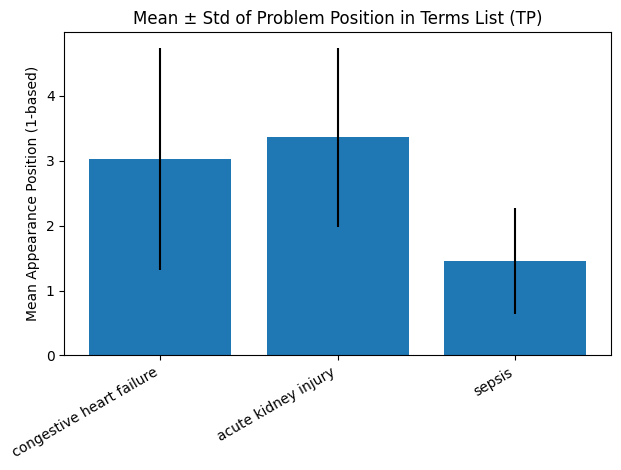

/tmp/ipykernel_928507/2834540992.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


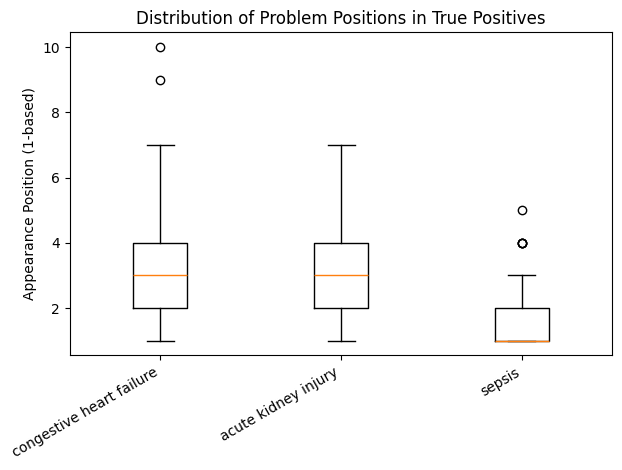

In [21]:
import numpy as np
import matplotlib.pyplot as plt

means = {p: np.mean(v) if v else np.nan for p,v in problems.items()}
stds  = {p: np.std(v)  if v else np.nan for p,v in problems.items()}

# 2) bar chart with error bars
plt.figure()
plt.bar(
    list(means.keys()),
    list(means.values()),
    yerr=[stds[p] for p in means],
)
plt.ylabel("Mean Appearance Position (1-based)")
plt.title("Mean ± Std of Problem Position in Terms List (TP)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# 3) boxplot of all positions
plt.figure()
plt.boxplot(
    [problems[p] for p in problems],
    labels=list(problems.keys())
)
plt.ylabel("Appearance Position (1-based)")
plt.title("Distribution of Problem Positions in True Positives")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()
